Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance
N-examples train 750
N-examples test 150
N-examples val 50


100%|██████████| 600/600 [02:35<00:00,  3.86it/s]

per-validation optimal epoch 596
torch.Size([150, 1024, 7])


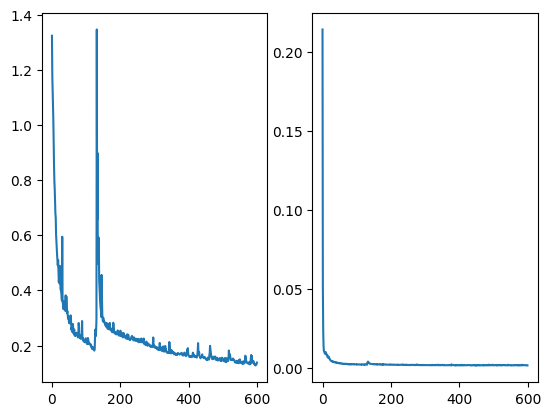

In [1]:
import torch
import numpy as np
import os
import os.path as osp
import tqdm
import matplotlib.pylab as plt
from torch import nn
from torch import optim
from collections import defaultdict

## Imports based on our ready-to-use code (after you pip-install the cs233_gtda_hw4 package)
from cs233_gtda_hw4.in_out.utils import make_data_loaders
from cs233_gtda_hw4.in_out.utils import save_state_dicts, load_state_dicts
from cs233_gtda_hw4.in_out import pointcloud_dataset
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud


## Imports you might use if you follow are scaffold code (it is OK to use your own stucture of the models)
from cs233_gtda_hw4.models import MyPointCloudAutoencoder
from cs233_gtda_hw4.models.point_net import MyPointNet
from cs233_gtda_hw4.models.mlp import MLP

%load_ext autoreload
%autoreload 2

##
## Fixed Settings (we do not expect you to change these)
## 

n_points = 1024  # number of points of each point-cloud
n_parts = 4      # max number of parts of each shape
n_train_epochs = 600

# Students: feel free to change below -ONLY- for the bonus Question:
# I.e., use THESE hyper-parameters when you train for the non-bonus questions.

part_lambda = 0.005  # for the part-aware AE you will be using (summing) two losses:
                     # chamfer + cross-entropy
                     # do it like this: chamfer + (part_lambda * cross-entropy), 
                     # i.e. we are scaling down the cross-entropy term
init_lr = 0.009#0.009  # initial learning-rate, tested by us with ADAM optimizer (see below)

## Students: feel free to change below:

# batch-size of data loaders
batch_size = 128 # if you can keep this too as is keep it, 
                 # but if it is too big for your GPU, feel free to change it.

# which device to use: cpu or cuda?
# device = 'cpu'     # Note: only the "alternative" (slower) chamfer_loss in losses/nn_distance can run in cpu.
device = 'cuda'

top_in_dir = 'cs233_gtda_hw4/data/'
top_out_dir = 'cs233_gtda_hw4/data/out/'
if not osp.exists(top_out_dir):
    os.makedirs(top_out_dir)

# PREPARE DATA: 2022, 2017
# torch.manual_seed(2022)
# torch.cuda.manual_seed(2022)
# np.random.seed(2022)

loaders = make_data_loaders(top_in_dir, batch_size)

for split, loader in loaders.items():
    print('N-examples', split, len(loader.dataset))
    
# BUILD MODELS:
### TODO: Student on your own:
class PartClassifier(nn.Module):
    def __init__(self, in_dim, n_parts):
        super(PartClassifier, self).__init__()
        self.hidden1 = nn.Conv1d(in_dim, 128, 1) # global features with points
        self.output1 = nn.Conv1d(128, n_parts, 1)

    def forward(self, pointclouds, global_features):
        global_features = global_features.unsqueeze(1).repeat(1, pointclouds.shape[1], 1)
        pointclouds = torch.cat([pointclouds, global_features], dim=2).transpose(1, 2)
        pcd_feature1 = self.output1(self.hidden1(pointclouds).relu()).transpose(1, 2) # (B, N, 1)
        return pcd_feature1
        
encoder = MyPointNet(init_feat_dim=7, conv_dims=[32, 64, 64, 128, 256])
decoder = MLP(256,3 * n_points, b_norm=True, dropout_rate=0.5)
part_classifier = PartClassifier(in_dim=256+3, n_parts=n_parts)

xentropy = nn.CrossEntropyLoss()
model = MyPointCloudAutoencoder(encoder, decoder, part_classifier).to(device) # Students Work here
model_tag = 'part_pc_ae_my'

optimizer = optim.Adam(model.parameters(), lr=init_lr)  # Students uncomment once you have defined your model

## Train for multiple epochs your model.
# Students: the below for-loops are optional, feel free to structure your training 
# differently.

min_val_loss = np.Inf
out_file = osp.join(top_out_dir, model_tag + 'best_model.pth')
start_epoch = 1
seg_losses = []
recon_losses = []
for epoch in tqdm.tqdm(range(start_epoch, start_epoch + n_train_epochs)):
    for phase in ['train', 'val', 'test']:
        # Students Work Here.
        epoch_recon_losses, epoch_seg_losses = model.train_with_part_one_epoch(loaders[phase], optimizer, num_classes=n_parts)
        if phase == 'val':
            seg_losses.append(epoch_seg_losses)
            recon_losses.append(epoch_recon_losses)
        epoch_losses = epoch_recon_losses + epoch_seg_losses
        # Save model if validation loss improved.
        if phase == 'val' and epoch_losses < min_val_loss:
            min_val_loss = epoch_losses
            save_state_dicts(out_file, epoch=epoch, model=model)
plt.subplot(1,2,1)
plt.plot(seg_losses, label='seg')
plt.subplot(1,2,2)
plt.plot(recon_losses, label='recon')

# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model)
print('per-validation optimal epoch', best_epoch)

# Last, save the latent codes of the test data and go to the 
# measuring_part_awareness and tsne_plot_with_latent_codes code.
model.eval()
latent_codes = []
point_clouds, part_masks, shape_names = loaders['test'].dataset.pointclouds, loaders['test'].dataset.part_masks, loaders['test'].dataset.model_names
# Students TODO: Extract the latent codes and save them, so you can analyze them later.
point_clouds = torch.from_numpy(point_clouds)
part_masks = torch.from_numpy(part_masks)
part_masks_onehot = torch.nn.functional.one_hot(part_masks.long(), n_parts).float()
input_data = torch.cat([point_clouds, part_masks_onehot], dim=-1).to(device)
latent_codes = model.embed(input_data).cpu().numpy()

print(input_data.shape)

np.savez(osp.join(top_out_dir, model_tag +'_latent_codes_my'), 
         latent_codes=latent_codes, 
         test_names=shape_names)